# Checkpoints & persistence
https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints

* Checkpointer config is used at compile time. Checkpoint requires one or more of following keys:
     - keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']
* Thread id is passed at run time

### Checkpointer memory:
* In memory (for debugging/testing)
* SQLLite
* PostgreSQL
* Custom : conforms to BaseCheckpointSaver

### Checkpointer benefits
1. Fault tolerance & Recovery
2. Cost & efficiency optimization
3. Reproducability / Time travel
4. Long running tasks


**Note**
In case you see unexpected results - retstart kernel and run all cells

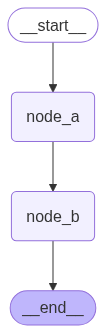

Executed : node_a
Executed : node_b


{'foo': 'a', 'bar': ['a', 'b']}

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from IPython.display import Image, display

# This is for JSON pretty print
from IPython.display import JSON

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

# Overwrites the value in foo
def node_a(state: State):
    print("Executed : node_a")
    return {"foo": "a"}

# Sets the bar = [value of foo] + [b]
def node_b(state: State):
    print("Executed : node_b")
    bar = [state["foo"]] + ["b"]
    return { "bar": bar}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

# Setup the checkpointer @ compile time
checkpointer = InMemorySaver()
graph_compiled = workflow.compile(checkpointer=checkpointer)

# Visualize
display(Image(graph_compiled.get_graph().draw_mermaid_png()))

# Invocation requires a thread_id in configuration
config = {"configurable": {"thread_id": "1"}}

# foo will be overwritten
graph_compiled.invoke({"foo": "X"}, config)


#### **Checkpoint** 
is a snapshot of the graph state saved at each super-step and is represented by StateSnapshot object with the following key properties:

**config:** Config associated with this checkpoint.

**metadata:** Metadata associated with this checkpoint.

**values:** Values of the state channels at this point in time.

**next:** A tuple of the node names to execute next in the graph.

**tasks:** A tuple of PregelTask objects that contain information about next tasks to be executed. If the step was previously attempted, it will include error information. If a graph was interrupted dynamically from within a node, tasks will contain additional data associated with interrupts.

In [2]:
# Utility for printing information in the snapshot
def print_snapshot(snapshot):
    print(f"Step-{snapshot.metadata["step"]}")
    print(f"Next={snapshot.next}")
    print(f"values={snapshot.values}")

    keys = snapshot.metadata.keys()
    for key in keys:
        print(f"\tmetadata[{key}] = {snapshot.metadata[key]}")

    print(f"config={snapshot.config}")
    print(f"parent_config={snapshot.parent_config}")
    print(f"created_at={snapshot.created_at}")


##### get_state

In [3]:
# Fetch the latest checkpoint using get_state
# https://langchain-ai.github.io/langgraph/concepts/persistence/#get-state
last_state = graph_compiled.get_state(config)

print_snapshot(last_state)


Step-2
Next=()
values={'foo': 'a', 'bar': ['a', 'b']}
	metadata[source] = loop
	metadata[step] = 2
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc7-69cc-8002-b8646ceaf390'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
created_at=2025-07-14T10:30:16.867066+00:00


### History
https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.CompiledStateGraph.get_state_history

You can get the history of graph states by using the get_state_history. 

**Expected checkpoints for the graph above**
- 4. checkpoint with the outputs of node_b {'foo': 'b', 'bar': ['a', 'b']} and no next nodes to be executed
- 3. checkpoint with the outputs of node_a {'foo': 'a', 'bar': ['a']} and node_b as the next node to be executed
- 2. checkpoint with the user input {'foo': '', 'bar': []} and node_a as the next node to be executed
- 1. empty checkpoint with START as the next node to be executed

##### get_state_history()

In [4]:
# Requires thread_id or checkpoint_id to get the history
def get_print_history(history):

    print(f"Snapshot count = {len(history)}")

    for snapshot in history:
        print_snapshot(snapshot)
        print("-----------------------------------------------")

history=list(graph_compiled.get_state_history(config))
get_print_history(history)

Snapshot count = 4
Step-2
Next=()
values={'foo': 'a', 'bar': ['a', 'b']}
	metadata[source] = loop
	metadata[step] = 2
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc7-69cc-8002-b8646ceaf390'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
created_at=2025-07-14T10:30:16.867066+00:00
-----------------------------------------------
Step-1
Next=('node_b',)
values={'foo': 'a', 'bar': []}
	metadata[source] = loop
	metadata[step] = 1
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc2-6afc-8000-d0fe5942170f'}}
created_at=2025-07-14T10:30:16.866062+00:00
----------------------------------------------

### Update the state
https://langchain-ai.github.io/langgraph/concepts/persistence/#update-state

You may update checkpoints (add) in the executed graph and run again from the point onwards

##### Identify the step/checkpoint that you want to update

In [5]:
# Checkout the snapshot at step-1
selected_state = history[1]
print(f"Next node = {selected_state.next}")
print(f"Snapshot = {selected_state.values}")

Next node = ('node_b',)
Snapshot = {'foo': 'a', 'bar': []}


##### update_state()

In [6]:
# Update the state of the graph, with new value and execute
new_config = graph_compiled.update_state(selected_state.config, values={"foo": "YYY"})
print(new_config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8c7b-6bd8-8002-fc05601ffae4'}}


In [7]:
# Checkpoint @ index 4 for Step-2 will override the output at Step-2 @ index 
history=list(graph_compiled.get_state_history(config))
get_print_history(history)

Snapshot count = 5
Step-2
Next=('node_b',)
values={'foo': 'YYY', 'bar': []}
	metadata[source] = update
	metadata[step] = 2
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8c7b-6bd8-8002-fc05601ffae4'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
created_at=2025-07-14T10:30:16.940847+00:00
-----------------------------------------------
Step-2
Next=()
values={'foo': 'a', 'bar': ['a', 'b']}
	metadata[source] = loop
	metadata[step] = 2
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc7-69cc-8002-b8646ceaf390'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
created_at=2025-07-14T10:30:16.867066+00:00
------------------------------------------

### Replay from sanpshot
https://langchain-ai.github.io/langgraph/concepts/persistence/#replay

You can replay th egraph from a snapshot onwards

#### Time travel
https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/

What is happening?
* We updated the state after *node_a* [foo = 'YYY' overwrote 'a']
* Next node to be executed is node_b
* After the execution of node_b the final state is {'foo': 'YYY', 'bar': ['YYY', 'b']}

In [8]:
print(f"new_config={new_config}")

# None indicates that execution of the graph starts @ specified checkpoint
graph_compiled.invoke(None, new_config)

new_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8c7b-6bd8-8002-fc05601ffae4'}}
Executed : node_b


{'foo': 'YYY', 'bar': ['YYY', 'b']}

##### Checkout the history again
* Pay attention to the count
* Check out the updated Step-2 & Step-3 

In [9]:
history=list(graph_compiled.get_state_history(config))
get_print_history(history)

Snapshot count = 6
Step-3
Next=()
values={'foo': 'YYY', 'bar': ['YYY', 'b']}
	metadata[source] = loop
	metadata[step] = 3
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8cba-6410-8003-1476f4ce4134'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8c7b-6bd8-8002-fc05601ffae4'}}
created_at=2025-07-14T10:30:16.966452+00:00
-----------------------------------------------
Step-2
Next=('node_b',)
values={'foo': 'YYY', 'bar': []}
	metadata[source] = update
	metadata[step] = 2
	metadata[parents] = {}
	metadata[thread_id] = 1
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8c7b-6bd8-8002-fc05601ffae4'}}
parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0609d8-8bc5-6295-8001-05ccfcefe601'}}
created_at=2025-07-14T10:30:16.940847+00:00
--------------------------------------